In [1]:
import os
import numpy as np
from astropy.io import fits
from glob import glob
import pandas as pd

from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground, SExtractorBackground

from imagedaemon.paths import CAL_DATA_DIR, RAW_DATA_DIR
from imagedaemon.image.winter_image import WinterImage
from imagedaemon.image.image_operations import plot_image

# Set up the paths to the calibration data
camname = "winter"
MASTERFLAT_DIR = os.path.join(CAL_DATA_DIR, camname, "masterflats")
MASTERDARK_DIR = os.path.join(CAL_DATA_DIR, camname, "masterdarks")
MASTERBIAS_DIR = os.path.join(CAL_DATA_DIR, camname, "masterbiases")


_PROJECT_ROOT = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon
CONFIG_DIR = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/config
astro_scamp = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/config/scamp.conf
masterbias_dir = /Users/nlourie/data/image-daemon-data/calibration/masterbias


Science image exposure time: 120.0 seconds
Found masterdark with matching exposure time: winter_masterdark_120.000s.fits
shape of masterdark single image: (1096, 1984)
shape of raw science frame: (1096, 1984)


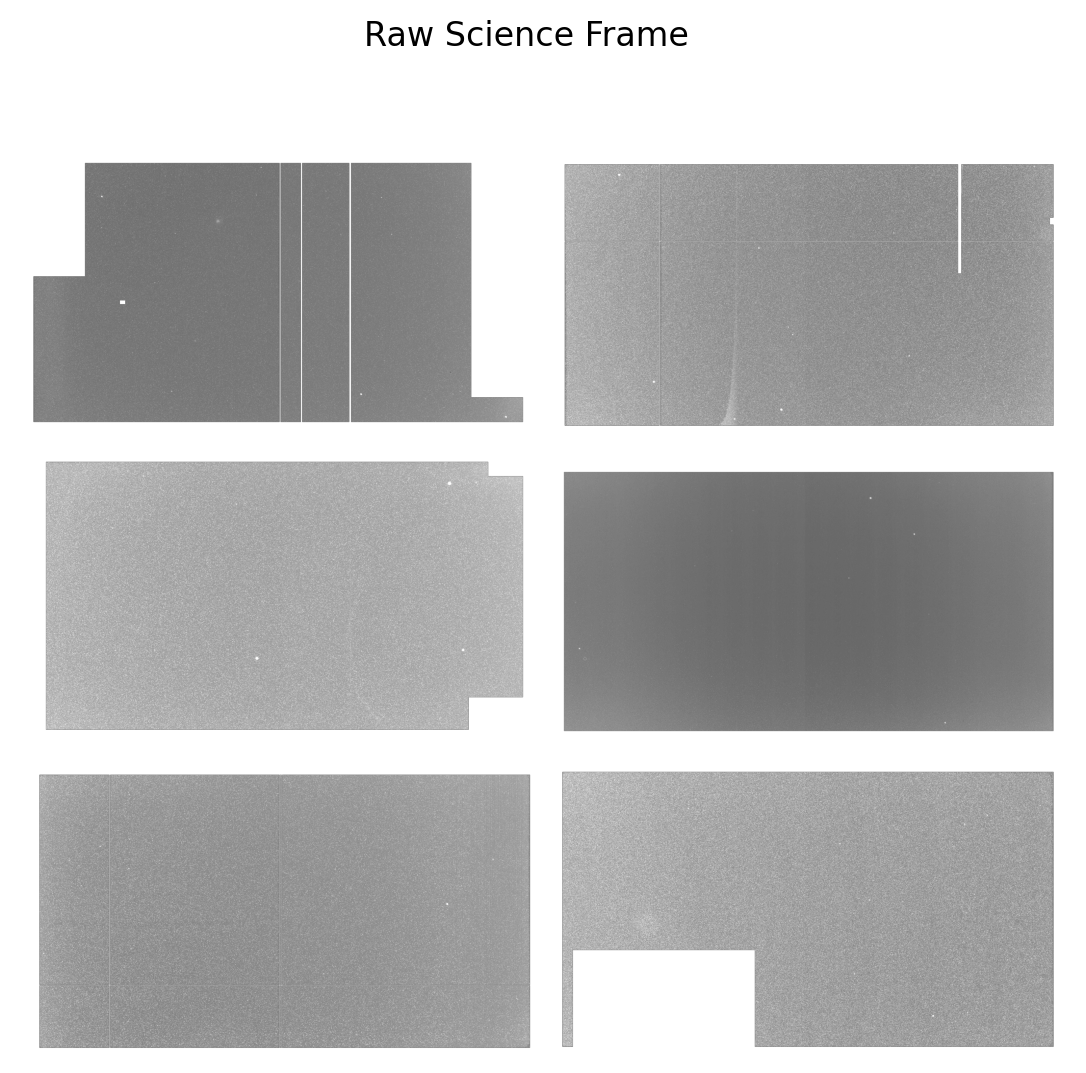

Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/science_dark_flat_corr_sa.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/science_dark_flat_corr_sb.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/science_dark_flat_corr_sc.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/science_dark_flat_corr_pa.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/science_dark_flat_corr_pb.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/science_dark_flat_corr_pc.fits


/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/image/winter_image.py:606: RuntimeWarning: divide by zero encountered in divide
  return {k: op(self.data[k], other.data[k]) for k in common}
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/image/winter_image.py:606: RuntimeWarning: invalid value encountered in divide
  return {k: op(self.data[k], other.data[k]) for k in common}


In [2]:

# Now load in a science frame. We will calibrate it.

science_raw_dir = os.path.join(RAW_DATA_DIR, camname, "science")
science_raw_files = sorted(glob(os.path.join(science_raw_dir, "*.fits")))
science_raw_file = science_raw_files[0]

# Load the science frame as a WinterImage
science_raw_image = WinterImage(science_raw_file)

# Load the master flat, dark, and bias frames
masterflat_image = WinterImage(os.path.join(MASTERFLAT_DIR, "masterflat.fits"))

# Get the dark frame at the same exposure time as the science frame. Raise an error if none is found.
exposure_time = science_raw_image.top_level_header["EXPTIME"]
print(f"Science image exposure time: {exposure_time} seconds")

masterdark_files = glob(os.path.join(MASTERDARK_DIR, "*.fits"))
for dark_file in masterdark_files:
    dark_image = WinterImage(dark_file)
    if dark_image.top_level_header["EXPTIME"] == exposure_time:
        print(f"Found masterdark with matching exposure time: {os.path.basename(dark_file)}")
        break
else:
    raise FileNotFoundError(f"No masterdark found with exposure time {exposure_time} seconds")
    

masterdark_image = WinterImage(masterdark_files[0])
print(f"shape of masterdark single image: {masterdark_image.data['pa'].shape}")
print(f"shape of raw science frame: {science_raw_image.data['pa'].shape}")

# plot the raw science frame
science_raw_image.plot_mosaic(title="Raw Science Frame")

# Dark correct the science frame
science_dark_corr = WinterImage(science_raw_image - masterdark_image, 
                                headers=science_raw_image.headers, 
                                top_level_header=science_raw_image.top_level_header)
#science_dark_corr.plot_mosaic(title="Dark Corrected Science Frame")

# Flat field correct the dark corrected frame
science_dark_flat_corr = WinterImage(science_dark_corr / masterflat_image, 
                                headers=science_raw_image.headers, 
                                top_level_header=science_raw_image.top_level_header)
#science_dark_flat_corr.plot_mosaic(title="Dark + Flat Corrected Science Frame")


science_dark_flat_corr.save_sensors(
    os.path.join(science_raw_dir, "science_dark_flat_corr.fits")
)


Header: XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1984                                                  NAXIS2  =                 1096                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXP_ACT =                120.0                                                  UNITS   = 'counts  '                                                            IMGTYPE = 'iwr     '                                                            READOUTM= 'iwr     '                                                            READOUTV=                  1.1                                                  GAINCOLT= '[1 1 1] '            

<Axes: title={'center': 'Raw Data: RA = 203.763301391715, DEC = -29.5469078126968'}>

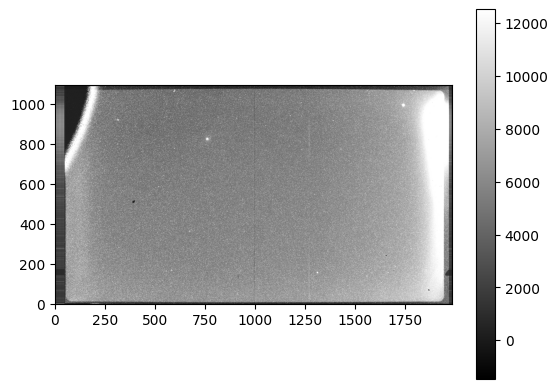

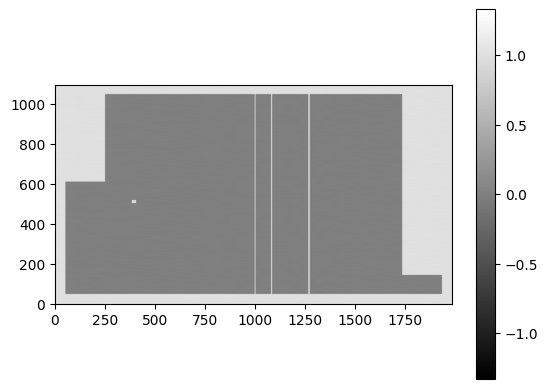

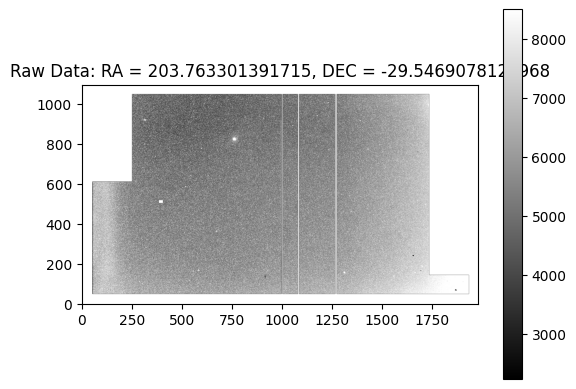

In [3]:
# Test out the mask generation
addr = "pc"
#img = science_dark_flat_corr
img = science_dark_corr



plot_image(img.data[addr])
plot_image(img.masks[addr])

data = img.data[addr]
mask = img.masks[addr]
header = img.headers[addr]
top_level_header = img.top_level_header
print(f"Header: {header}")

"""
# Test out on another file?
test_file_board_4 = os.path.join(os.path.dirname(RAW_DATA_DIR), "test", "winter", "test","WINTERcamera_20250221-073341-459_mef_4_0_0.fits")
print(f"Test File: {test_file_board_4}")
data = fits.getdata(test_file_board_4)
top_level_header = fits.getheader(test_file_board_4)
"""

data[mask] = np.nan

plot_image(data, title = f"Raw Data: RA = {top_level_header['RADEG']}, DEC = {top_level_header['DECDEG']}")




shape of median data: (1096, 1984)
shape of masterdark image: (1096, 1984)
shape of median data dark corrected: (1096, 1984)


Running astrometry.net with command: solve-field /Users/nlourie/data/image-daemon-data/raw/winter/science/tmp/tmp.fits --scale-units arcsecperpix --scale-low 1.0 --scale-high 1.2 --overwrite --ra 203.763301391715 --dec -29.5469078126968 --radius 1.0
STDOUT: Reading input file 1 of 1: "/Users/nlourie/data/image-daemon-data/raw/winter/science/tmp/tmp.fits"...
Running command: /opt/homebrew/bin/image2pnm --infile /Users/nlourie/data/image-daemon-data/raw/winter/science/tmp/tmp.fits --uncompressed-outfile /tmp/tmp.uncompressed.Eg4hCF --outfile /tmp/tmp.ppm.G11cga --ppm --mydir /opt/homebrew/bin/solve-field
Extracting sources...
simplexy: found 3909 sources.
Making source extraction overlay plot -- pnmfn = /tmp/tmp.ppm.G11cga
Solving...
Reading file "/Users/nlourie/data/image-daemon-data/raw/winter/science/tmp/tmp.axy"...
Only searching for solutions within 1 degrees of RA,Dec (203.763,-29.5469)
Field 1 did not solve (index index-5202-41.fits, field objects 1-10).
Field 1 did not solve (ind

<Axes: title={'center': 'Solved Image'}>

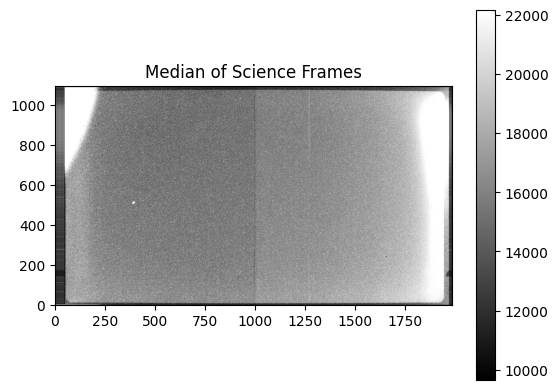

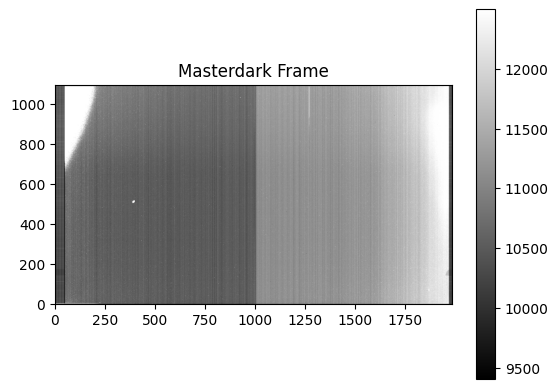

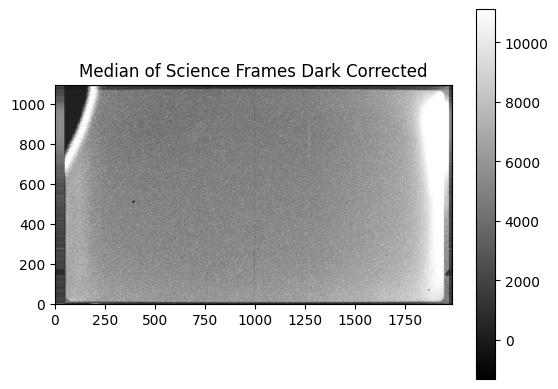

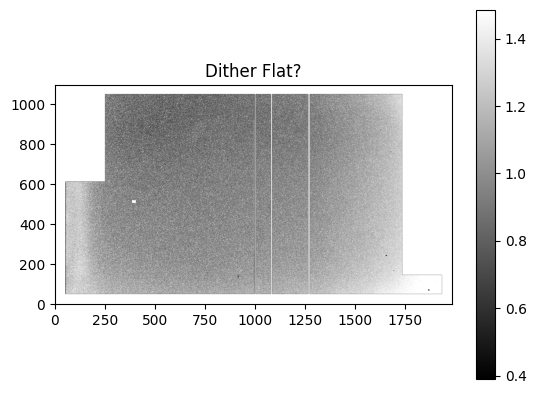

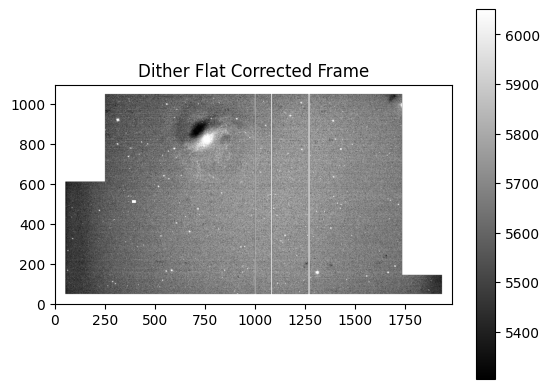

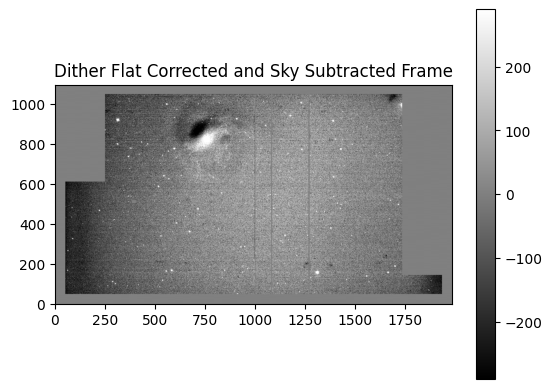

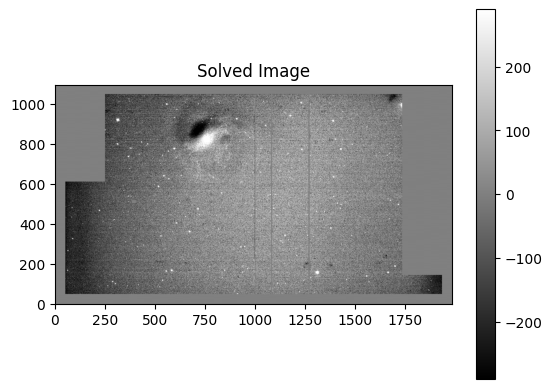

In [4]:
# Make sky model using multiple science frames
tmp_dir = os.path.join(science_raw_dir, "tmp")
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)
science_files = sorted(glob(os.path.join(science_raw_dir, "*mef.fits")))
# make winter images for each science file
science_images = []
for science_file in science_files:
    science_image = WinterImage(science_file)
    science_images.append(science_image)
    #plot_image(science_image.data[addr], title=os.path.basename(science_file))

median_data = np.nanmedian([img.data[addr] for img in science_images], axis=0)
plot_image(median_data, title="Median of Science Frames")
plot_image(masterdark_image.data[addr], title="Masterdark Frame")
print(f"shape of median data: {median_data.shape}")
print(f"shape of masterdark image: {masterdark_image.data[addr].shape}")

median_data_dark_corr = median_data - masterdark_image.data[addr]
print(f"shape of median data dark corrected: {median_data_dark_corr.shape}")
#median_data_dark_corr[mask] = np.nan
plot_image(median_data_dark_corr, title="Median of Science Frames Dark Corrected")

# turn the median into a flat?
median_dither_flat  = median_data_dark_corr / np.nanmedian(median_data_dark_corr)
median_dither_flat[mask] = np.nan
plot_image(median_dither_flat, title="Dither Flat?")


# divide the science frame by the dither flat
data_dither_flat_corr = data / median_dither_flat
data_dither_flat_corr[mask] = np.nan
plot_image(data_dither_flat_corr, title="Dither Flat Corrected Frame")
# save the dither flat corrected data to a new file
hdu_dither_flat_corr = fits.PrimaryHDU(data=data_dither_flat_corr, header=header)
#hdu_dither_flat_corr.writeto(os.path.join(tmp_dir, "tmp.fits"), overwrite=True)

# subtract the median background from the science frame
data_dither_flat_corr_skysub = data_dither_flat_corr - np.nanmedian(data_dither_flat_corr)
data_dither_flat_corr_skysub[mask] = np.nanmedian(data_dither_flat_corr_skysub)
plot_image(data_dither_flat_corr_skysub, title="Dither Flat Corrected and Sky Subtracted Frame")
# save the dither flat corrected and sky subtracted data to a new file
hdu_dither_flat_corr_skysub = fits.PrimaryHDU(data=data_dither_flat_corr_skysub, header=header)
output_filepath = os.path.join(tmp_dir, "tmp.fits")
hdu_dither_flat_corr_skysub.writeto(output_filepath, overwrite=True)


"""
# subtract the median sky from the science frame
data_dither_sky_sub = data - median_data_dark_corr
data_dither_sky_sub[mask] = np.nan
plot_image(data_dither_sky_sub, title="Dither Sky Subtracted Frame")
# save the dither sky subtracted data to a new file
saved_data = data_dither_sky_sub.copy()

hdu_dither_sky_sub = fits.PrimaryHDU(data=saved_data, header=header)
hdu_dither_sky_sub.writeto(os.path.join(tmp_dir, "tmp.fits"), overwrite=True)
"""
"""
# save to tmp file

# Save the data to a temporary file
tmp_file = os.path.join(tmp_dir,"tmp.fits")
hdu = fits.PrimaryHDU(data=data, header=header)
hdu.writeto(tmp_file, overwrite=True)

from imagedaemon.sextractor.sextractor import run_sextractor

catname = run_sextractor(tmp_file, weightimg=None, regions=True)

# read in the catalog and mask the sources


# Read in the background file
bkg_file = os.path.join(tmp_dir, "tmp.back.fits")
bkg_data = fits.getdata(bkg_file)
plot_image(bkg_data, title="Background Frame from SExtractor")

# subtract the background from the data
data_bkgsub = (saved_data - bkg_data)
plot_image(data_bkgsub, title="Background Subtracted Frame")

# save the background subtracted data to a new file
hdu_bkgsub = fits.PrimaryHDU(data=data_bkgsub, header=header)
hdu_bkgsub.writeto(os.path.join(tmp_dir, "tmp_bkgsub.fits"), overwrite=True)"""




# This is the call: 
radeg = top_level_header["RADEG"]
decdeg = top_level_header["DECDEG"]
shell_cmd = f"solve-field {output_filepath} --scale-units arcsecperpix --scale-low 1.0 --scale-high 1.2 --overwrite --ra {radeg} --dec {decdeg} --radius 1.0"
print(f"Running astrometry.net with command: {shell_cmd}")
# Run the command using subprocess and capture the output
import subprocess
import shlex

# Run the command using subprocess and capture the output
process = subprocess.Popen(shlex.split(shell_cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
# Print the output and error messages
print("STDOUT:", stdout.decode())
print("STDERR:", stderr.decode())
# Check the return code to see if the command was successful
if process.returncode == 0:
    print("Command executed successfully.")
else:
    print(f"Command failed with return code {process.returncode}.")
    print("Error message:", stderr.decode())
    raise RuntimeError(f"Command failed with return code {process.returncode}.")

# Now read in the astrometry.net output file
solved_image_file = os.path.join(tmp_dir, "tmp.new")
solved_image = fits.getdata(solved_image_file)
plot_image(solved_image, title="Solved Image")


In [13]:
# Now we want to do a background subtraction on each sensor
background_data = {}
for addr in science_raw_image.data.keys():
    print(f"Processing sensor {addr}:")
    data = science_dark_flat_corr.data[addr]
    from astropy.stats import sigma_clipped_stats, SigmaClip
    from photutils.segmentation import detect_threshold, detect_sources
    from photutils.utils import circular_footprint
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    threshold = detect_threshold(data, nsigma=2.0, sigma_clip=sigma_clip)
    segment_img = detect_sources(data, threshold, npixels=10)
    footprint = circular_footprint(radius=10)
    mask = segment_img.make_source_mask(footprint=footprint)

    # Create a SigmaClip object to identify outliers
    sigma_clip = SigmaClip(sigma=3.0)
    # Create a MedianBackground object to estimate the background
    bkg_estimator = MedianBackground()
    # Create a Background2D object to perform the background estimation
    bkg = Background2D(data, (10, 10), filter_size=(5, 5),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,
                       coverage_mask=mask, fill_value=0)
    #print(f"Background mean: {bkg.background_mean}, Background median: {bkg.background_median}")

    # Plot the background image

    
    
    background_data[addr] = bkg.background

background = WinterImage(background_data,
                        headers=science_raw_image.headers, 
                        top_level_header=science_raw_image.top_level_header)
background.plot_mosaic(title="Background Frame")

science_dark_flat_bkg_corr = WinterImage(science_dark_flat_corr - background,
                                         headers=science_raw_image.headers, 
                                         top_level_header=science_raw_image.top_level_header)
science_dark_flat_bkg_corr.plot_mosaic(title="Dark + Flat + Background Corrected Science Frame", norm_by="sensor")

# save each sensor to a separate file
science_dark_flat_bkg_corr.save_sensors(os.path.join(science_raw_dir, "science_dark_flat_bkg_corr"))

# Now we want to run astrometry.net tools on the saved file and capture the output


Processing sensor sa:


Processing sensor sb:


Processing sensor sc:


Processing sensor pa:


Processing sensor pb:


Processing sensor pc:


/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/image/winter_image.py:320: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/science_dark_flat_bkg_corr_sa.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/science_dark_flat_bkg_corr_sb.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/science_dark_flat_bkg_corr_sc.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/science_dark_flat_bkg_corr_pa.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/science_dark_flat_bkg_corr_pb.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/science_dark_flat_bkg_corr_pc.fits


In [14]:
from mirar.pipelines.winter.load_winter_image import get_raw_winter_mask
for addr in science_raw_image.data.keys():
    print(f"Processing sensor {addr}, Board ID: {science_raw_image._board_id_by_addr[addr]}")



Processing sensor sa, Board ID: 2
Processing sensor sb, Board ID: 6
Processing sensor sc, Board ID: 5
Processing sensor pa, Board ID: 1
Processing sensor pb, Board ID: 3
Processing sensor pc, Board ID: 4


In [15]:
# Test out the mask generation
addr = "pc"
#img = science_dark_flat_corr
img = science_dark_corr
#plot_image(img.data[addr])
#plot_image(img.masks[addr])

data = img.data[addr]
mask = img.masks[addr]
header = img.headers[addr]
data[mask] = np.nan

plot_image(data)

from astropy.convolution import convolve, Tophat2DKernel

# let's try the smoothing way to get the background
tophat_kernel = Tophat2DKernel(20)

data_smoothed = convolve(data, tophat_kernel)

plot_image(data_smoothed, title="Smoothed Data")

data_bkdsub = data - data_smoothed
plot_image(data_bkdsub, title="Background Subtracted Data")

# now identify sources, we will add these to the mask
from photutils.segmentation import detect_sources, make_2dgaussian_kernel, SourceCatalog

threshold = 3.*np.nanstd(data_bkdsub)
print(f"Threshold: {threshold}")

# Create a 2D Gaussian kernel for the source detection
kernel = make_2dgaussian_kernel(3.0, size=3) # FWHM of 3.0 pixels, size of 3x3 pixels
convolved_data = convolve(data_bkdsub, kernel)
plot_image(convolved_data, title="Convolved Data")
segm = detect_sources(convolved_data, threshold, npixels=5)
plot_image(segm.data, title="Segmented Data")

# now let's mask 10 pixel circular regions around the sources
print(f"sources: {segm.data}")



Threshold: 7476.90234375
sources: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [16]:
cat = SourceCatalog(data_bkdsub, segm)
print(f"cat: {cat}")

ax = plot_image(data_bkdsub, title="Background Subtracted Data with Sources")
source_mask_radius = 20
cat.plot_circular_apertures(radius = source_mask_radius, ax=ax, color='red', lw=1.5)

# now let's mask these apertures with specified radius
mask_apertures = cat.make_circular_apertures(radius=source_mask_radius)
print(f"mask_apertures: {mask_apertures}")

# existing mask: False (0) = good pixel, True (1) = masked
mask_with_apertures = mask.copy().astype(bool)

for ap in cat.make_circular_apertures(radius=source_mask_radius):
    # 1. tiny bounding‑box mask around this source
    ap_mask = ap.to_mask(method="center")          # ApertureMask

    # 2. expand it to the full image size
    full_mask = ap_mask.to_image(mask.shape)       # ndarray, 1 inside, 0 outside  :contentReference[oaicite:0]{index=0}

    # 3. convert to boolean and add it to the master mask
    mask_with_apertures |= full_mask.astype(bool)



# visual check
plot_image(mask_with_apertures.astype(int),
           title="Mask with Sources (1 = masked)")

# now let's make a copy of the data and mask the sources
data_with_sources_masked = data.copy()
data_with_sources_masked[mask_with_apertures] = np.nan
plot_image(data_with_sources_masked, title="Data with Sources Masked")

# now let's fit the background to the data with sources masked

data_with_sources_masked_smoothed = convolve(data_with_sources_masked, tophat_kernel)

plot_image(data_with_sources_masked_smoothed, title="Smoothed Data")

data_bkdsub = data - data_with_sources_masked_smoothed
plot_image(data_bkdsub, title="Background Subtracted Data")

# save the data to a new file
hdu_bkdsub = fits.PrimaryHDU(data=data_bkdsub, header=header)
hdu_bkdsub.writeto(os.path.join(tmp_dir, "tmp_bkdsub.fits"), overwrite=True)

cat: <photutils.segmentation.catalog.SourceCatalog>
Length: 22
labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
mask_apertures: [<CircularAperture([1596.5006048,   50.       ], r=20.0)>, <CircularAperture([796.5005793, 132.       ], r=20.0)>, <CircularAperture([1311.08368342,  156.56127702], r=20.0)>, <CircularAperture([1664.41709124,  156.94242554], r=20.0)>, <CircularAperture([582.75495916, 167.56210888], r=20.0)>, <CircularAperture([1698.75146403,  187.49131871], r=20.0)>, <CircularAperture([672.81189133, 361.03121171], r=20.0)>, <CircularAperture([772.49275065, 495.9842376 ], r=20.0)>, <CircularAperture([517.07801207, 585.53694322], r=20.0)>, <CircularAperture([1072.57848736,  591.90328414], r=20.0)>, <CircularAperture([1604.41376555,  660.13412448], r=20.0)>, <CircularAperture([1428.48739302,  771.56593791], r=20.0)>, <CircularAperture([596.25450598, 774.42102827], r=20.0)>, <CircularAperture([313.16077529, 796.80235558], r=20.0)>, <CircularAperture([760